# Synthetic Experiment Setup: Sentiment on IMDB

Goal: Create a range of synthetic datasets on which the ATE estimator should always identify that "the reward for sentiment is not affected by changes to length", even though an artifical correlation is gradually introduced. Meanwhile, the naive conditional estimate will report higher and higher sensitivity of the same reward function to length.

Assuming we choose a reward function which really is just measuring sentiment and not length (!), this would strongly demonstrate that the naive conditional estimate can fail even in toy settings, but the ATE estimator doesn't.

In [33]:
# Load imdb for examples
from datasets import load_dataset
import pandas as pd
from sklearn.metrics import mutual_info_score
import numpy as np

# Batch API related imports
from openai import OpenAI # OpenAI API
import json # for creating batch files

# And for loading the API key from the .env file
from dotenv import load_dotenv
import os

import torch
import torch.nn.functional as F
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification

import matplotlib.pyplot as plt

### Truncate the IMDB dataset

In [2]:
# load imdb dataset from huggingface
dataset = load_dataset('imdb')

# Creating separate DataFrames for train and test data
train_df = pd.DataFrame({'text': dataset['train']['text'], 'label': dataset['train']['label']})
test_df = pd.DataFrame({'text': dataset['test']['text'], 'label': dataset['test']['label']})

# Concatenate the DataFrames
imdb = pd.concat([train_df, test_df], ignore_index=True)

# # Remove samples which have length greater than 4000 characters
# imdb = imdb[imdb['text'].apply(lambda x: len(x) < 4000)]

# # Reset the index after filtering
# imdb = imdb.reset_index(drop=True)

# Bin text lengths
imdb.loc[:, 'text_length'] = imdb['text'].str.len()
# set the length threshold to be the median length
length_threshold = imdb['text_length'].median()
print(f"Median length of text: {length_threshold}")
imdb['is_long'] = imdb['text_length'] > length_threshold

Median length of text: 970.0


In [3]:
# make sure is_long got assigned correctly
print(imdb['is_long'].value_counts())
assert (imdb['is_long'] == (imdb['text'].str.len() > length_threshold)).all()

is_long
False    25003
True     24997
Name: count, dtype: int64


### Check the dataset looks right

In [4]:
# summarize how many of each label there are
imdb['label'].value_counts()

label
0    25000
1    25000
Name: count, dtype: int64

<Axes: >

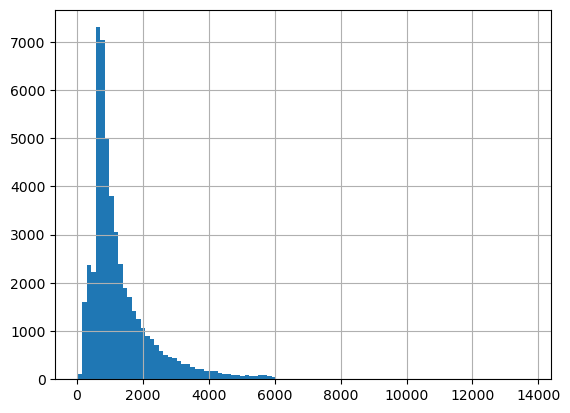

In [5]:
# plot distribution of how many characters are in each review
imdb['text_length'].hist(bins=100)

In [6]:
# summary statistics of how many characters are in each review
imdb['text_length'].describe()

count    50000.000000
mean      1309.431020
std        989.728014
min         32.000000
25%        699.000000
50%        970.000000
75%       1590.250000
max      13704.000000
Name: text_length, dtype: float64

In [7]:
# compare the means and medians of the length of reviews for each label
print(imdb.groupby('label')['text_length'].mean())
print(imdb.groupby('label')['text_length'].median())

label
0    1294.06436
1    1324.79768
Name: text_length, dtype: float64
label
0    973.0
1    968.0
Name: text_length, dtype: float64


In [8]:
# using correlation coefficient
imdb[['label', 'text_length']].corr()

,label,text_length
label,1.000000,0.015526
text_length,0.015526,1.000000


In [9]:
# check the mutual information between the label and the text length
mi = mutual_info_score(imdb['label'], imdb['is_long'])
mi

6.055212308120339e-06

Good! Length and label appear to be independent. That means that we can gradually introduce a correlation and test how sensitive the conditional vs. causal estimates are!

So long as our reward model *truly depends on sentiment and not length*, the correct answer should be "no effect observed", even as more correlation is added.

### Get rewrites from OpenAI Batch API

In [10]:
# Get rewrites from OpenAI batch API for entire imdb dataset, while preserving the order (index) of the dataset

# Setup the OpenAI client
load_dotenv()
client = OpenAI(
    # This is the default and can be omitted
    api_key=os.environ.get("OPENAI_API_KEY"),
)

In [11]:
# # Types of rewrite instructions

# flipped_length = "shorter" if is_long else "longer"
#     counterfactual_prompt = f"""
# Original Review: 
# {review}
# [Adjust the original review so it's {flipped_length}, but change *nothing* else about the review (just the review, no external formatting is necessary).]
# """

# # Extract the first 3 words of the review, to use as a guide for the model
#     first_3_words = "\n".join(review.split()[:3])

#     # Prompt to the model to rewrite the review to be loquacious or pithy (opposite of whether it was short or long to begin with.)
#     counterfactual_prompt = f"""
# Original Review: 
# {review}
# [Adjust the original review so it's {flipped_length}, but change *nothing* else about the review.]
# Adjusted Review:{first_3_words}"""

# flipped_length = "shorter" if is_long else "longer"
#     counterfactual_prompt = f"""
# Original Review: 
# {review}
# [Adjust the original review so it's {flipped_length}, but change *nothing* else about the review. Just make it shorter or longer.]
# """
# flipped_length = "shorter" if is_long else "longer"
#     counterfactual_prompt = f"""
# Original Review: 
# {review}
# [Rewrite the original review so it's {flipped_length}, but change *nothing* else about the review.]
# Adjusted Review:
# """
# flipped_length = "smaller wordcount" if is_long else "larger wordcount"
#     counterfactual_prompt = f"""
# Original Review: 
# {review}
# [Adjust the original review so it has a {flipped_length}, but change *nothing* else about the review.]
# Adjusted Review:
# """
# flipped_length = "smaller wordcount by making it more pithy" if is_long else "larger wordcount by making it less pithy"
#     counterfactual_prompt = f"""
# Original Review: 
# {review}
# [Adjust the original review so it has a {flipped_length}, but change *nothing* else about the review.]
# Adjusted Review:
# """
# flipped_length = "more pithy, less long" if is_long else "more long, less pithy"
#     counterfactual_prompt = f"""
# Original Completion: 
# {review}
# [Adjust the original completion so it's {flipped_length}, but change *nothing* else.]
# Adjusted Completion:
#     """
# flipped_length = "pithy" if is_long else "loquacious"
#     counterfactual_prompt = f"""
# Original Completion: 
# {review}
# [Adjust the original completion so it's more {flipped_length}, but change *nothing* else.]
# Adjusted Completion:
#     """
# flipped_length = "longer" if is_long == 0 else "shorter"
#     counterfactual_prompt = f"""
#     Original Completion: 
#     {review}
#     [Adjust the original completion so it's {flipped_length}, but change *nothing* else.]
#     Adjusted Completion:
#     """
# flipped_length = "longer" if is_long == 0 else "shorter"
#     counterfactual_prompt = f"""
#     Original Completion: 
#     {review}
#     [Adjust the original completion so it's 50% {flipped_length}, but change *nothing* else.]
#     Adjusted Completion:
#     """

# probably worth asking chatgpt for a range of possible rewrite instructions, if I want to test sensitivity.

In [12]:
def review_messages(review, is_long):
    """ Prompt to the model to rewrite the review to be loquacious or pithy (opposite of whether it was short or long to begin with.) """

    assert type(is_long) == bool, (f"Expected is_long to be a boolean, but got {is_long}",review,is_long)
    if is_long:
        assert len(review) > length_threshold, f"Review is too short: {len(review)}"
    flipped_length = "shorter" if is_long else "longer"
    counterfactual_prompt = f"""{review}\n\n[Adjust this review so it's {flipped_length}, but change *nothing* else.]
"""
    
    messages=[
                {
                    "role": "user",
                    "content": counterfactual_prompt,
                },
            ]
    return messages

# create each line of the batch input file
def write_input_jsonl(df, batch_input_filename):
    batch_input = []
    for idx, row in df.iterrows():
        messages = review_messages(row['text'], row['is_long'])
        batch_input.append({
            "custom_id": str(idx),
            "method": "POST",
            "url": "/v1/chat/completions",
            "body": {
                "model": "gpt-4o-2024-08-06",
                "messages": messages,
                "temperature": 0.7
            }
        })
    # save the batch input file as jsonl
    with open(batch_input_filename, 'w') as f:
        for item in batch_input:
            json.dump(item, f)  # Properly escape quotes and special characters
            f.write("\n")  # Ensure each JSON object is on a new line


In [13]:
sample_size = 100
# sample the imdb dataset
sampled_imdb = imdb.sample(sample_size, random_state=42)

In [14]:
# create the batch input file with a random identifier
file_id = np.random.randint(0, 10000)
batch_input_filename = f"../data/batch_api/imdb_batch_input_{file_id}.jsonl"
print(batch_input_filename)

# write the batch input file
write_input_jsonl(sampled_imdb, batch_input_filename)

../data/batch_api/imdb_batch_input_7403.jsonl


In [15]:
# Upload the batch file
batch_input_file = client.files.create(
    file=open(batch_input_filename, "rb"),
    purpose="batch"
)

# Create the batch job
batch = client.batches.create(
    input_file_id=batch_input_file.id,
    endpoint="/v1/chat/completions",
    completion_window="24h",
    metadata={
        "description":"test run"
    }
)
print(batch)

Batch(id='batch_fyVSwqjqKHPDrge5gDvOSYv9', completion_window='24h', created_at=1725159711, endpoint='/v1/chat/completions', input_file_id='file-gE0v4Lej8g4unkE9VuPhCcTb', object='batch', status='validating', cancelled_at=None, cancelling_at=None, completed_at=None, error_file_id=None, errors=None, expired_at=None, expires_at=1725246111, failed_at=None, finalizing_at=None, in_progress_at=None, metadata={'description': 'test run'}, output_file_id=None, request_counts=BatchRequestCounts(completed=0, failed=0, total=0))


In [16]:
# Retrieve and print the details of the batch
print(client.batches.retrieve(batch.id).status)

completed


In [17]:
# create the batch output file
batch_output_filename = f"../data/batch_api/imdb_batch_output_{file_id}.jsonl"
print(batch_output_filename)

# Retrieve the output file and write it to a local file
content = client.files.content(client.batches.retrieve(batch.id).output_file_id)
content.write_to_file(batch_output_filename)

../data/batch_api/imdb_batch_output_7403.jsonl


In [26]:
# Process the outputs and merge them with the original DataFrame
custom_ids = []
contents = []

# Read and parse the JSON lines
with open(batch_output_filename, 'r') as file:
    for line in file:
        data = json.loads(line)
        custom_id = data.get('custom_id')
        content = data['response']['body']['choices'][0]['message']['content']
        
        custom_ids.append(int(custom_id))
        contents.append(content)

# Create a DataFrame from the extracted data
rewrites = pd.DataFrame({
    'sample_id': custom_ids,
    'rewritten_review': contents
})

# Merge the DataFrames
merged_df = pd.merge(sampled_imdb, rewrites, left_index=True, right_on='sample_id')

# Display the merged DataFrame
merged_df.head()


,text,label,text_length,is_long,sample_id,rewritten_review
0,Forget what I said about Emeril. Rachael Ray i...,0,925,False,33553,Forget what I said about Emeril. Rachael Ray i...
1,Former private eye-turned-security guard ditch...,0,1155,True,9427,Former private eye-turned-security guard ditch...
2,Mann photographs the Alberta Rocky Mountains i...,0,787,False,199,Mann photographs the Alberta Rocky Mountains i...
3,Simply put: the movie is boring. Cliché upon c...,0,986,True,12447,"The movie is boring, filled with clichés, and ..."
4,"Now being a fan of sci fi, the trailer for thi...",1,416,False,39489,"Now, being a fan of sci-fi, I must admit that ..."


### Setup the Sentiment classifier

We'll use a common classifer.

In [29]:
sentiment_tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased-finetuned-sst-2-english")
sentiment_model = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased-finetuned-sst-2-english")

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

In [36]:
def get_sentiment_score(review):
    inputs = sentiment_tokenizer(review, return_tensors="pt", truncation=True)

    if inputs['input_ids'].shape[1] > 512:
        chunk_size = 512
        input_ids = inputs['input_ids'].squeeze(0)
        attention_mask = inputs['attention_mask'].squeeze(0)

        chunked_probs = []
        for i in range(0, input_ids.size(0), chunk_size):
            input_chunk = input_ids[i:i + chunk_size].unsqueeze(0)
            attention_chunk = attention_mask[i:i + chunk_size].unsqueeze(0)
            with torch.no_grad():
                logits = sentiment_model(input_ids=input_chunk, attention_mask=attention_chunk).logits
                probs = F.softmax(logits, dim=-1)
            chunked_probs.append(probs)

        # Compute geometric mean of probabilities across chunks
        mean_probs = torch.exp(torch.mean(torch.log(torch.stack(chunked_probs)), dim=0))

        # Convert the mean probabilities back to logits
        logits = torch.log(mean_probs)
    else:
        with torch.no_grad():
            logits = sentiment_model(**inputs).logits

    positive_logit = logits[0, 1].item()  # Directly return the logit for positive sentiment

    return positive_logit

# Apply the sentiment classifier to both the original and rewritten reviews
merged_df['orig_reward'] = merged_df['text'].apply(get_sentiment_score)
merged_df['rewrite_reward'] = merged_df['rewritten_review'].apply(get_sentiment_score)

In [37]:
merged_df

,text,label,text_length,is_long,sample_id,rewritten_review,orig_reward,rewrite_reward
0,Forget what I said about Emeril. Rachael Ray i...,0,925,False,33553,Forget what I said about Emeril. Rachael Ray i...,-3.711692,-2.278748
1,Former private eye-turned-security guard ditch...,0,1155,True,9427,Former private eye-turned-security guard ditch...,-1.772361,-2.544573
2,Mann photographs the Alberta Rocky Mountains i...,0,787,False,199,Mann photographs the Alberta Rocky Mountains i...,0.454779,0.521912
3,Simply put: the movie is boring. Cliché upon c...,0,986,True,12447,"The movie is boring, filled with clichés, and ...",-3.819314,-3.796844
4,"Now being a fan of sci fi, the trailer for thi...",1,416,False,39489,"Now, being a fan of sci-fi, I must admit that ...",4.446308,4.399087
...,...,...,...,...,...,...,...,...
95,Rebar is an astronaut who goes on the world's ...,0,993,True,3928,Rebar is an astronaut who goes on the world's ...,-3.502153,-3.335153
96,I went to see this film because it was recomme...,0,3274,True,37286,I went to see this film because it was recomme...,-1.636145,0.688747
97,"STMD! is not a terrible movie, but it IS quite...",0,721,False,25045,"STMD! is not a terrible movie, but it IS quite...",-3.368389,-3.504114
98,Pakeezah has a very interesting history (which...,1,974,True,15727,"Pakeezah has a fascinating history, as destiny...",4.019710,4.454218


ok...now the reward seems to be working correctly. I'll need to run it on the cluster for any larger experiment, however.

### Strategy for Creating Gradual Correlation
Bin Text Lengths

- Texts are divided into two bins based on their length:
        - Texts longer than 1200 characters
        - Texts shorter than or equal to 1200 characters
    - Note: Given a truncation at 4000 characters, each bin is equally likely to be sampled when reviewing either positive or negative samples, ensuring an initial uniform distribution across bins.

Initial Distribution

    - The initial distribution across the two bins is modeled as a Bernoulli distribution with p=0.5, indicating no initial correlation between text length and sentiment:
        - P(long∣positive)=0.5
        - P(long∣negative)=0.5

Gradual Increase in Correlation

    - A sequence of DataFrames will be generated to represent a gradually increasing correlation between long reviews and positive sentiments:
        - For each experiment iteration i from 1 to 10:
            - Initialize the ith DataFrame.
            - For each sample j from 1 to num_samples:
                - Sample the sentiment sj​ from Bernoulli(0.5), where 1 represents a positive sentiment and 0 represents a negative sentiment.
                - Conditionally sample the review length:
                    - If sj​ is positive, sample from the long bin with P(long∣sj=positive)=0.5+0.05*i
                    - If sj​ is negative, sample from the long bin with P(long∣sj=negative)=0.5−0.05*i

Target Distribution for Perfect Correlation

    - In the final step (i=10), achieve perfect correlation:
        - P(long∣positive)=1: All long reviews will be positive.
        - P(long∣negative)=0: No long reviews will be negative.

In [95]:
# Parameters
num_dfs = 10
num_samples = sample_size // num_dfs
assert num_samples >= 10, "Number of samples per DataFrame is too low"
print("Number of samples per DataFrame:", 2*num_samples)

# Split the dataset into long and short texts
long_texts = merged_df[merged_df['is_long']]
short_texts = merged_df[~merged_df['is_long']]
print(long_texts.shape, short_texts.shape)

# Initialize list to hold the DataFrames
correlated_dataframes = []

# Generate a sequence of DataFrames with increasing correlation
for i in range(1, num_dfs + 1):
    # Define probabilities for long reviews based on the current iteration
    p_long_positive = 0.5 + 0.05 * i
    p_long_negative = 0.5 - 0.05 * i

    # Determine how many long texts should be selected for each sentiment
    num_long_positive = np.random.binomial(num_samples, p_long_positive)
    num_long_negative = np.random.binomial(num_samples, p_long_negative)

    # Sample texts based on the computed probabilities
    positive_samples = pd.concat([
        long_texts[long_texts['label'] == 1].sample(num_long_positive, replace=False),
        short_texts[short_texts['label'] == 1].sample(num_samples - num_long_positive, replace=False)
    ])

    negative_samples = pd.concat([
        long_texts[long_texts['label'] == 0].sample(num_long_negative, replace=False),
        short_texts[short_texts['label'] == 0].sample(num_samples - num_long_negative, replace=False)
    ])

    # Combine positive and negative samples
    combined_samples = pd.concat([positive_samples, negative_samples]).sample(frac=1).reset_index(drop=True)

    # Append the DataFrame to the list
    correlated_dataframes.append(combined_samples)

# `correlated_dataframes` now contains the DataFrames with increasing correlation

(49, 8) (51, 8)


### Checks to make sure the dataframes are set up correctly

In [96]:
# provide header, summary statistics, and a few examples for each dataframe
for i, df in enumerate(correlated_dataframes):
    print(f"DataFrame {i + 1}")
    print(df['label'].value_counts())
    print(df['text'].str.len().describe())
    print(df.head())
    print("\n")

DataFrame 1
label
1    10
0    10
Name: count, dtype: int64
count      20.000000
mean     1160.150000
std       691.215274
min       412.000000
25%       722.750000
50%       868.500000
75%      1485.000000
max      2895.000000
Name: text, dtype: float64
                                                text  label  text_length  \
0  Best Stephen King film alongside IT, though th...      1          725   
1  This is definitely an appropriate update for t...      1         1173   
2  Normally I wouldn't go to the trouble of comme...      0          790   
3  In 'Hoot' Logan Lerman plays Roy Eberhardt, th...      1          893   
4  I think Micheal Ironsides acting career must b...      0          864   

   is_long  sample_id                                   rewritten_review  \
0    False      18471  Sure, here's an extended version of your revie...   
1     True      22367  This update is fitting, except now "party on t...   
2    False      27578  Normally, I wouldn't go to the troubl

In [97]:
# check the mutual information between the label and the text length for each of the generated dataframes
mi_values = []

for i, df in enumerate(correlated_dataframes):
    df['text_length'] = df['text'].str.len()
    df['is_long'] = df['text_length'] > length_threshold
    mi = mutual_info_score(df['label'], df['is_long'])
    mi_values.append(mi)

mi_values

[0.005508654502557331,
 0.0,
 0.08630462173553427,
 0.006701781822267688,
 0.08228287850505128,
 0.4228104552401627,
 0.5255973270178642,
 0.13250545091704735,
 0.693147180559945,
 0.693147180559945]

In [98]:
# compute the entropy of each of the generated dataframes
entropy_values = []

for i, df in enumerate(correlated_dataframes):
    entropy = df['label'].value_counts(normalize=True).map(lambda x: x * np.log(x)).sum()
    entropy_values.append(entropy)

entropy_values

[-0.6931471805599453,
 -0.6931471805599453,
 -0.6931471805599453,
 -0.6931471805599453,
 -0.6931471805599453,
 -0.6931471805599453,
 -0.6931471805599453,
 -0.6931471805599453,
 -0.6931471805599453,
 -0.6931471805599453]

In [99]:
# calculate the correlation coefficient between the label and the text length for each of the generated dataframes
correlation_values = []

for i, df in enumerate(correlated_dataframes):
    df['text_length'] = df['text'].str.len()
    correlation = df[['label', 'text_length']].corr().iloc[0, 1]
    correlation_values.append(correlation)

correlation_values

[-0.06434487666016184,
 0.2512778097979349,
 0.06238637300540848,
 0.17036670516389263,
 0.33026144163386556,
 0.4902455280443433,
 0.5710975336779259,
 0.40578202883246006,
 0.62686823143785,
 0.6904385075138917]

<Figure size 1200x600 with 0 Axes>

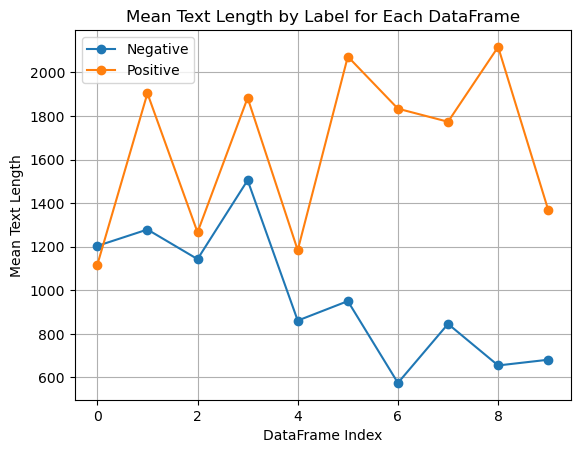

In [100]:
# Compute and plot mean text length by label for each DataFrame
mean_text_lengths = []

for i, df in enumerate(correlated_dataframes):
    mean_text_length = df.groupby('label')['text_length'].mean()
    mean_text_lengths.append(mean_text_length)

# Convert the list of Series to a DataFrame
mean_text_lengths_df = pd.DataFrame(mean_text_lengths)

# Correctly set the index to the DataFrame index
mean_text_lengths_df.index = range(len(correlated_dataframes))

# Plot the mean text length by label for each DataFrame
plt.figure(figsize=(12, 6))
mean_text_lengths_df.plot(marker='o')

plt.xlabel("DataFrame Index")
plt.ylabel("Mean Text Length")
plt.title("Mean Text Length by Label for Each DataFrame")
plt.legend(["Negative", "Positive"])
plt.grid(True)
plt.show()

In [101]:
# provide one random review from each of the generated dataframes, and print the text length and label
for i, df in enumerate(correlated_dataframes):
    print(f"DataFrame {i}")
    print(f"Overall Correlation: {correlation_values[i]:.4f}")
    print(df.sample(1)['text'].values[0][:200])
    print(f"Sample length: {len(df.sample(1)['text'].values[0])}")
    print(f"Label: {df.sample(1)['label'].values[0]}")
    print()

DataFrame 0
Overall Correlation: -0.0643
I think Micheal Ironsides acting career must be over, if he has to star in this sort of low budge crap. Surely he could do better than waste his time in this rubbish.<br /><br />This movie could be fa
Sample length: 790
Label: 0

DataFrame 1
Overall Correlation: 0.2513
I have always wanted to see this because I love cheesy horror movies and with a title like this, I was sure "The Incredible Melting Man" would be a lot of fun.<br /><br />It really wasn't. I mean, the
Sample length: 5188
Label: 1

DataFrame 2
Overall Correlation: 0.0624
This is definitely an appropriate update for the original, except that "party on the left is now party on the right." Like the original, this movie rails against a federal government which oversteps i
Sample length: 825
Label: 1

DataFrame 3
Overall Correlation: 0.1704
While killing time on a Saturday morning, "Looking For Lola" came on HBO. I decided to give it a shot even though the description of the movie looke

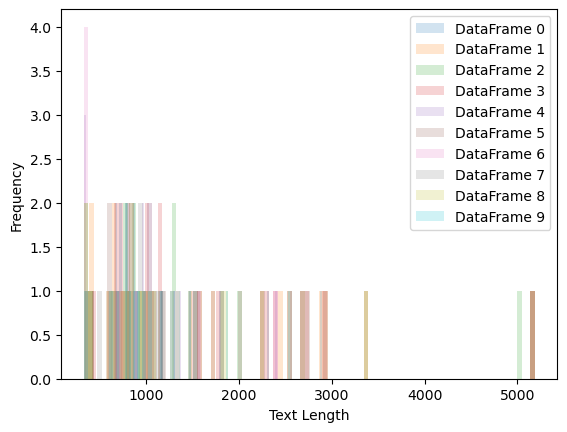

In [102]:
# Plot histogram of lengths for each df to ensure there is no bias
fig, ax = plt.subplots()

for i, df in enumerate(correlated_dataframes):
    ax.hist(df['text'].str.len(), bins=100, alpha=0.2, label=f"DataFrame {i}")

ax.set_xlabel('Text Length')
ax.set_ylabel('Frequency')
ax.legend()
plt.show()

### Ok I'm reasonably sure these dataframes are setup correctly

## Compute the effect of length on the sentiment classifer, for each correlated df

In [103]:
# # match Todd's formatting:

# dataset = [
#         {
#             "w_original": True,
#             "completions": {
#                 "original": 'Review: "The Grand Adventure" is a cinematic gem that captures the essence of friendship and perseverance. With stunning visuals and an emotionally charged storyline, the film takes audiences on a journey filled with laughter and heartfelt moments. The performances from the lead actors are nothing short of spectacular, adding depth to the already immersive plot. Each scene is beautifully crafted, making it a must-see for anyone who cherishes uplifting tales that resonate long after the credits roll. A truly delightful experience!',
#                 "rewrite": 'Review: "The Grand Adventure" is a cinematic disappointment that fails to capture the essence of friendship and perseverance. With lackluster visuals and a muddled storyline, the film takes audiences on a journey filled with awkward moments and forced laughter. The performances from the lead actors are nothing short of mediocre, detracting from the already shallow plot. Each scene feels poorly crafted, making it a film to avoid for anyone who cherishes uplifting tales that quickly fade from memory. A truly frustrating experience!',
#             },
#             "scores": {
#                 "original": 1.2636224031448364,
#                 "rewrite": -0.3159920573234558,
#             },
#         },
#         {
#             "w_original": False,
#             "completions": {
#                 "original": "Review: \"The flick attempts to balance deep emotional storytelling with action-packed sequences, but ultimately falters under the weight of its own ambitions. The characters feel underdeveloped, and their motivations are often unclear. While there are moments of beautiful cinematography, they aren't enough to save the film from its meandering plot. It's a missed opportunity that could have been something truly special.\"",
#                 "flipped": 'Review: "The flick attempts to balance deep emotional storytelling with action-packed sequences, and while it may not fully achieve this balance, it offers some intriguing moments. The characters have potential, and their motivations provide a glimpse into their journeys. There are moments of beautiful cinematography that elevate the experience, making it an enjoyable watch despite its meandering plot. It\'s a film that leaves you hopeful for what could come next."',
#             },
#             "scores": {
#                 "original": 1.339202642440796,
#                 "rewrite": 0.2303696721792221,
#             },
#         },
#     ]

In [104]:
merged_df

,text,label,text_length,is_long,sample_id,rewritten_review,orig_reward,rewrite_reward
0,Forget what I said about Emeril. Rachael Ray i...,0,925,False,33553,Forget what I said about Emeril. Rachael Ray i...,-3.711692,-2.278748
1,Former private eye-turned-security guard ditch...,0,1155,True,9427,Former private eye-turned-security guard ditch...,-1.772361,-2.544573
2,Mann photographs the Alberta Rocky Mountains i...,0,787,False,199,Mann photographs the Alberta Rocky Mountains i...,0.454779,0.521912
3,Simply put: the movie is boring. Cliché upon c...,0,986,True,12447,"The movie is boring, filled with clichés, and ...",-3.819314,-3.796844
4,"Now being a fan of sci fi, the trailer for thi...",1,416,False,39489,"Now, being a fan of sci-fi, I must admit that ...",4.446308,4.399087
...,...,...,...,...,...,...,...,...
95,Rebar is an astronaut who goes on the world's ...,0,993,True,3928,Rebar is an astronaut who goes on the world's ...,-3.502153,-3.335153
96,I went to see this film because it was recomme...,0,3274,True,37286,I went to see this film because it was recomme...,-1.636145,0.688747
97,"STMD! is not a terrible movie, but it IS quite...",0,721,False,25045,"STMD! is not a terrible movie, but it IS quite...",-3.368389,-3.504114
98,Pakeezah has a very interesting history (which...,1,974,True,15727,"Pakeezah has a fascinating history, as destiny...",4.019710,4.454218


In [105]:
def calculate_ate(dataset):
    do_w_1 = 0
    do_w_0 = 0
    w_1 = 0
    w_0 = 0
    w_1_count = 0
    for example in dataset:
        if example["w_original"]:
            do_w_1 += example["reward"]["original"]
            do_w_0 += example["reward"]["rewrite"]
            w_1_count += 1

            w_1 += example["reward"]["original"]
        else:
            do_w_1 += example["reward"]["rewrite"]
            do_w_0 += example["reward"]["original"]

            w_0 += example["reward"]["original"]

    n = len(dataset)
    do_w_1_mean = do_w_1 / n
    do_w_0_mean = do_w_0 / n

    ATE = do_w_1_mean - do_w_0_mean

    w_1_mean = w_1 / w_1_count
    w_0_mean = w_0 / (n - w_1_count)
    correlational_effect = w_1_mean - w_0_mean

    do_w_1_ssd = 0  # Sum of squared deviations for do_w_1
    do_w_0_ssd = 0  # Sum of squared deviations for do_w_0

    for example in dataset:
        if example["w_original"]:
            do_w_1_diff = example["reward"]["original"] - do_w_1_mean
            do_w_0_diff = example["reward"]["rewrite"] - do_w_0_mean
        else:
            do_w_1_diff = example["reward"]["rewrite"] - do_w_1_mean
            do_w_0_diff = example["reward"]["original"] - do_w_0_mean

        do_w_1_ssd += do_w_1_diff**2
        do_w_0_ssd += do_w_0_diff**2

    do_w_1_var = do_w_1_ssd / (n - 1)
    do_w_0_var = do_w_0_ssd / (n - 1)

    return ATE, do_w_1_var, do_w_0_var, correlational_effect

In [106]:
def calculate_effects(df):
    # use todd's formatting to organize the data from merged_df
    dataset = []
    for idx, row in df.iterrows():
        dataset.append(
            {
                "w_original": row['is_long'],
                "completions": {
                    "original": row['text'],
                    "rewrite": row['rewritten_review'],
                },
                "reward": {
                    "original": row['orig_reward'],
                    "rewrite": row['rewrite_reward'],
                },
            }
        )

    ATE, do_w_1_var, do_w_0_var, correlational_effect = calculate_ate(dataset)
    return ATE, do_w_1_var, do_w_0_var, correlational_effect

In [107]:
ATE, do_w_1_var, do_w_0_var, correlational_effect = calculate_effects(merged_df)
print("ATE:", ATE)
print("Variance of do_w_1:", do_w_1_var)
print("Variance of do_w_0:", do_w_0_var)
print("Correlational effect:", correlational_effect)

ATE: 0.15842561036348343
Variance of do_w_1: 10.857625293395758
Variance of do_w_0: 10.729229796637936
Correlational effect: -0.4418744510676967


### Now for the correlated dataframes

In [108]:
ATE_values = []
correlational_effect_values = []

for df in correlated_dataframes:
    ATE, do_w_1_var, do_w_0_var, correlational_effect = calculate_effects(df)
    ATE_values.append(ATE)
    correlational_effect_values.append(correlational_effect)


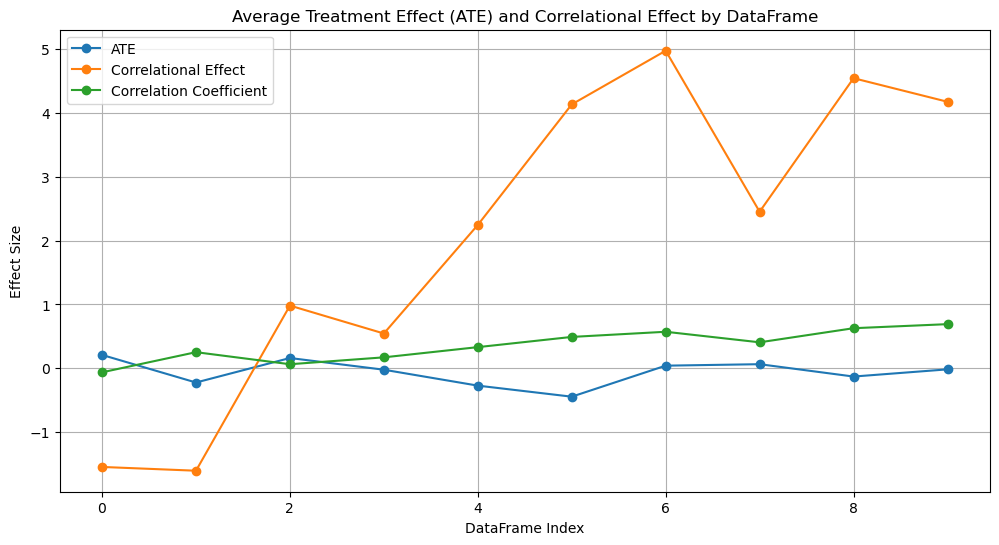

In [109]:

# plot the ATE and correlational effect for each of the generated dataframes
plt.figure(figsize=(12, 6))
plt.plot(ATE_values, marker='o', label="ATE")
plt.plot(correlational_effect_values, marker='o', label="Correlational Effect")
plt.plot(correlation_values, marker='o', label="Correlation Coefficient")
plt.xlabel("DataFrame Index")
plt.ylabel("Effect Size")
plt.title("Average Treatment Effect (ATE) and Correlational Effect by DataFrame")
plt.legend()
plt.grid(True)
plt.show()

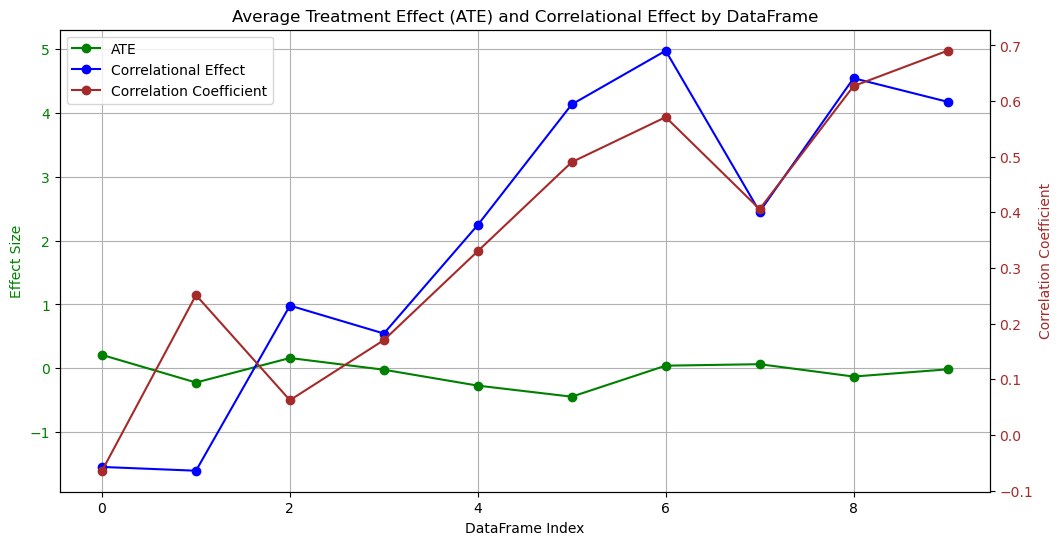

In [110]:
# Create the plot
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot ATE and Correlational Effect on the primary y-axis (left)
ax1.plot(ATE_values, marker='o', color='green', label="ATE")
ax1.plot(correlational_effect_values, marker='o', color='blue', label="Correlational Effect")
ax1.set_xlabel("DataFrame Index")
ax1.set_ylabel("Effect Size", color='green')
ax1.tick_params(axis='y', labelcolor='green')

# Create a secondary y-axis (right) for the correlation coefficient
ax2 = ax1.twinx()
ax2.plot(correlation_values, marker='o', color='brown', label="Correlation Coefficient")
ax2.set_ylabel("Correlation Coefficient", color='brown')
ax2.tick_params(axis='y', labelcolor='brown')

# Title and grid
plt.title("Average Treatment Effect (ATE) and Correlational Effect by DataFrame")
ax1.grid(True)

# Legend handling
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc='best')

# Show the plot
plt.show()

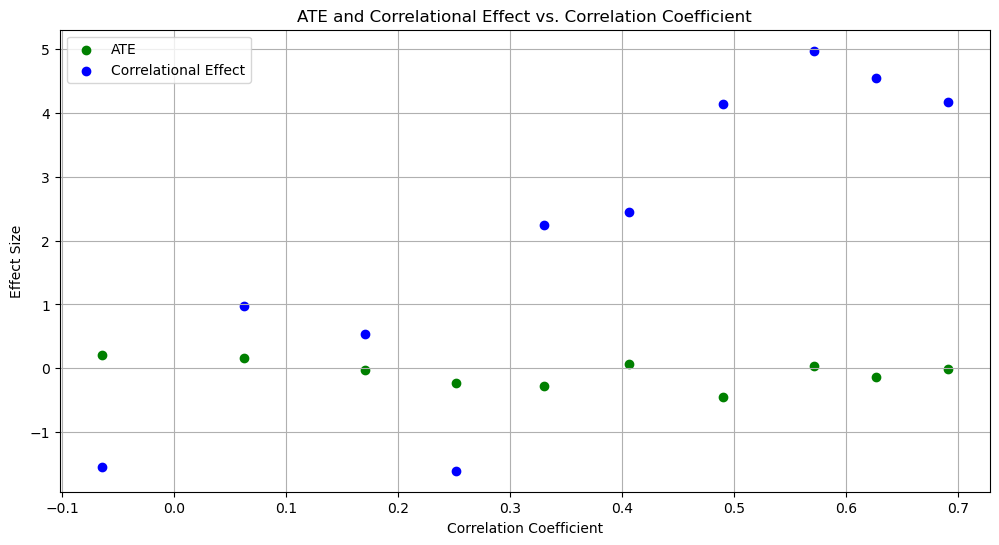

In [111]:
# Create the plot with correlation coefficients on the x-axis
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot ATE and Correlational Effect against correlation coefficients
ax1.scatter(correlation_values, ATE_values, marker='o', color='green', label="ATE")
ax1.scatter(correlation_values, correlational_effect_values, marker='o', color='blue', label="Correlational Effect")

# Set labels and title
ax1.set_xlabel("Correlation Coefficient")
ax1.set_ylabel("Effect Size")
ax1.set_title("ATE and Correlational Effect vs. Correlation Coefficient")

# Add grid and legend
ax1.grid(True)
ax1.legend(loc='best')

# Show the plot
plt.show()


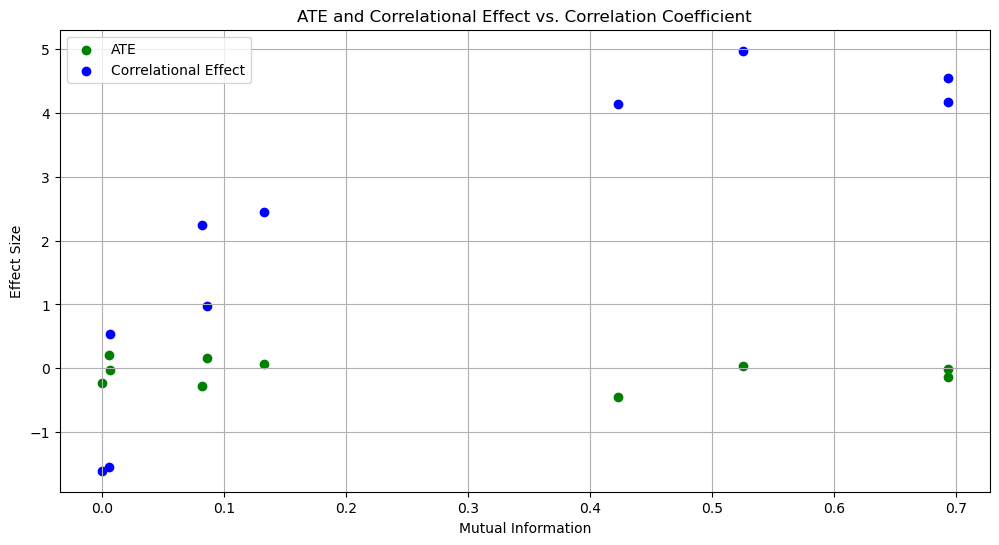

In [112]:
# Create the plot with correlation coefficients on the x-axis
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot ATE and Correlational Effect against correlation coefficients
ax1.scatter(mi_values, ATE_values, marker='o', color='green', label="ATE")
ax1.scatter(mi_values, correlational_effect_values, marker='o', color='blue', label="Correlational Effect")

# Set labels and title
ax1.set_xlabel("Mutual Information")
ax1.set_ylabel("Effect Size")
ax1.set_title("ATE and Correlational Effect vs. Correlation Coefficient")

# Add grid and legend
ax1.grid(True)
ax1.legend(loc='best')

# Show the plot
plt.show()


### Next steps
- find a reward function which is *only measuring sentiment and nothing else*! I think any competant sentiment classifier should do. (just take the output of the classifier to be the reward value)
- Calculate both the conditional and ATE estimates on each df in correlated_dfs
    - to do this, you'll need to rewrite each of the reviews, etc, and save in the format the standard pipeline uses
- plot the trends for the conditional and ATE effect estimates, against an x-axis of mutual information
    - or for a simple MVP, just the indices 1-10.
    - I'm not sure if a scatterplot with x-axis of mutual information or x-axis of correlation coefficient is better: maybe try both and see which looks more linear.

### A hypothtical results section:

In the case where the ground truth of the effect is known, we can directly show that it is recovered better by the RewriteATE estimator than the conditional estimator. 

Specifically, consider the following case where the ground truth effect should be zero: How much does length affect a sentiment classifer on IMDB reviews with increasing amounts of artificial correlation introduced?

We start with the IMDB dataset of 50000 reviews; we drop 1509 reviews whose length exceed 4000 characters to reduce outliers, leaving us with 48491 reviews. We bin reviews as "long" or "short" based on whether their length exceeds the mean length of 1200 characters: the length of the review and the sentiment are statistically independent (low mutual information, Pearson coefficient). Both positive and negative reviews are equally likely across both bins. (The distribution of initial review lengths is shown in Figure ?)

We analyze the Sentiment classifer of [monkeys et. al.], which is known not to be sensitive to changes in length (this is by design; we also validate this in the case of movie reviews, by showing that it does not favor long reviews in the original IMDB dataset, see Figure 2). Hence, we know the ground truth that it is not sensitive to length.

We then evaulated the correlational and RewriteATE estimators on samples drawn from IMDB with increasing amounts of correlation between long and positive reviews. In Figure 3, we show that the correlational estimator incorrectly claims that monkey's Sentiment classifier is sensitive to length, proportional to the amount of mutual information added between length and sentiment. On the other hand, the RewriteATE estimator reports correctly that the effect of length on the reward is negligable. (However, it's not perfect: note that it does report a small amount of effect for perfectly correlated datasets, which we attribute to slight imperfections in the rewrite process.)